In [73]:
#確定版 動画作成版（入力はすでに 606x408：右/下4pxトリム＋列510-512/行310-312削除後）
# ・境界線はギャップ帯（x:498-507, y:300-309）を塗る（食い込みゼロ、クロスは端まで）
# ・外枠はパディング側のみ（右下角落とし、上/左は延長して角つなぎ）
# ・スケールバー 48.84px を小数まで厳密（端1列をα合成）

import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

# ===== フォント（macOS）=====
def load_font(path_candidates, size):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                pass
    return ImageFont.load_default()

font_size = 20
font   = load_font([
    "/System/Library/Fonts/Supplemental/Arial.ttf",
    "/Library/Fonts/Arial.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)
font_I = load_font([
    "/System/Library/Fonts/Supplemental/Arial Italic.ttf",
    "/Library/Fonts/Arial Italic.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

def put_text(img_bgr, text, position, font_obj, color=(255,255,255)):
    img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_obj, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# ===== スケールバー（小数まで厳密）=====
def draw_fractional_scalebar(img_bgr, start_xy, length_px, bar_height_px=6, color=(255,255,255)):
    x0, y0 = start_xy
    L_full = int(np.floor(length_px))
    frac   = float(length_px - L_full)

    pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).convert("RGBA")
    overlay = Image.new("RGBA", pil.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    if L_full > 0:
        draw.rectangle([x0, y0, x0 + L_full - 1, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], 255))
    if frac > 1e-6:
        alpha = int(round(255 * frac))
        x_edge = x0 + L_full
        draw.rectangle([x_edge, y0, x_edge, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], alpha))

    composed = Image.alpha_composite(pil, overlay).convert("RGB")
    return cv2.cvtColor(np.array(composed), cv2.COLOR_RGB2BGR)

# ===== 三面図レイアウト定数（新仕様）=====
# 入力は最終 606x408（XY=498x300, GAP=10, ZY=98, XZ=98）
XY_W, XY_H = 498, 300
GAP        = 10
ZY_W, ZY_H = 98, 300
XZ_W, XZ_H = 498, 98
PANEL_W    = XY_W + GAP + ZY_W   # 606
PANEL_H    = XY_H + GAP + XZ_H   # 408

# ===== 外枠（角落とし）＋ギャップ塗り（クロス）=====
def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y,
                             XY_W, XY_H, XZ_H, ZY_W, GAP,
                             border_thickness=4, color=(255,255,255)):
    """
    ・ギャップ帯を塗る（食い込みゼロ）
    ・外枠はパディング側のみ＆右下角落とし
    ・上/左の帯を左右/上下に t ピクセル延長し、角を必ず重ねる（隙間対策）
    """
    PANEL_W = XY_W + GAP + ZY_W
    PANEL_H = XY_H + GAP + XZ_H

    h, w = canvas_bgr.shape[:2]
    t = int(border_thickness)
    WHITE = color

    def rect_fill(x0, y0, x1, y1):
        x0 = max(0, min(w-1, x0))
        y0 = max(0, min(h-1, y0))
        x1 = max(0, min(w-1, x1))
        y1 = max(0, min(h-1, y1))
        if x1 >= x0 and y1 >= y0:
            cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

    # ギャップ帯（x:498-507, y:300-309 を塗る）
    x_v0 = panel_x + XY_W             # 498
    x_v1 = x_v0 + GAP - 1             # 507
    rect_fill(x_v0, panel_y, x_v1, panel_y + PANEL_H - 1)

    y_h0 = panel_y + XY_H             # 300
    y_h1 = y_h0 + GAP - 1             # 309
    rect_fill(panel_x, y_h0, panel_x + PANEL_W - 1, y_h1)

    # 外枠（上/左を延長して角を確実に接続）※右下は角落とし
    # 上
    rect_fill(panel_x - t, panel_y - t, panel_x + PANEL_W - 1 + t, panel_y - 1)
    # 左
    rect_fill(panel_x - t, panel_y - t, panel_x - 1, panel_y + PANEL_H - 1 + t)
    # 右（下から XZ_H 分短く）
    rect_fill(panel_x + PANEL_W, panel_y, panel_x + PANEL_W + t - 1, panel_y + PANEL_H - 1 - XZ_H)
    # 下（右から ZY_W 分短く）
    rect_fill(panel_x, panel_y + PANEL_H, panel_x + PANEL_W - 1 - ZY_W, panel_y + PANEL_H + t - 1)

# ===== パス設定 =====
base_path = Path("/Users/yuusuke/Downloads/Videos/True_Video9")
input_path  = base_path / "plot_video_ch1_affine_bleachcorrect (1)_modified_606x408.avi"  # ←新仕様
output_path = base_path / "movie8_labeled_worm2_v3_606x408.mp4"
timestamp_csv_path = base_path / "Worm2_Timestamps.csv"

# ===== 入力 =====
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

fps        = 50.943  # 既知値を固定。必要なら cap.get(cv2.CAP_PROP_FPS) に変更可
frame_count= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
W0         = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H0         = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if (W0, H0) != (PANEL_W, PANEL_H):
    print(f"⚠️ 入力フレームサイズが新仕様(606x408)と異なります: {W0}x{H0}. 続行します。")

# ===== タイムスタンプ =====
df = pd.read_csv(timestamp_csv_path)
if "Delta" not in df.columns:
    raise ValueError("❌ CSVに 'Delta' 列が見つかりません")
timestamps = df["Delta"].to_numpy()
if len(timestamps) < frame_count:
    timestamps = np.pad(timestamps, (0, frame_count - len(timestamps)), mode="edge")

# ===== 出力（パディングぶん加算）=====
pad = 10
out_w, out_h = W0 + pad*2, H0 + pad*2
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(str(output_path), fourcc, fps, (out_w, out_h))
if not out.isOpened():
    cap.release()
    raise RuntimeError("❌ 出力動画が作成できません")

# ===== 描画定数 =====
WHITE = (255, 255, 255)
border_thickness = 4
panel_x, panel_y = pad, pad

# ラベル位置（新仕様に合わせて据え置き）
label_positions = {
    "xy": (panel_x + 10,                       panel_y + XY_H - 30),
    "xz": (panel_x + 10,                       panel_y + XY_H + GAP),
    "zy": (panel_x + XY_W + GAP + ZY_W - 30,   panel_y + XY_H - 30),
}

# スケールバー（48.84 px = 20 μm / 0.4095 μm/px）をxy面の右下付近に
scale_length_px = 20.0 / 0.4095  # ≈ 48.84...
scale_bar_height = 6
scalebar_start = (panel_x + XY_W - 60, panel_y + XY_H - 20)

print(f"▶ 出力 {out_w}x{out_h}, fps={fps:.3f}, frames={frame_count}")
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # 入力はすでに 606x408（右/下4px + 列/行削除後）想定：追加のクロップはしない
    # パディング追加（外枠はこの外側に描く）
    canvas = cv2.copyMakeBorder(frame, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=(0,0,0))

    # タイムスタンプ（左上）
    canvas = put_text(canvas, f"T = {timestamps[i]:.3f} s",
                      (panel_x + 10, panel_y + 10), font, WHITE)

    # ラベル（イタリック）
    for text, pos in label_positions.items():
        canvas = put_text(canvas, text, pos, font_I, WHITE)

    # スケールバー（小数まで厳密）
    canvas = draw_fractional_scalebar(canvas, start_xy=scalebar_start,
                                      length_px=scale_length_px,
                                      bar_height_px=scale_bar_height, color=WHITE)

    # ギャップ塗り＋外枠（角落とし／角つなぎ）
    draw_ortho_overlays_no_L(
        canvas, panel_x=panel_x, panel_y=panel_y,
        XY_W=XY_W, XY_H=XY_H, XZ_H=XZ_H, ZY_W=ZY_W, GAP=GAP,
        border_thickness=border_thickness, color=WHITE
    )

    out.write(canvas)

cap.release()
out.release()
print("✅ 完了:", str(output_path))


▶ 出力 626x428, fps=50.943, frames=1725
✅ 完了: /Users/yuusuke/Downloads/Videos/True_Video9/movie8_labeled_worm2_v3_606x408.mp4


In [74]:
# 確定版　先頭フレームだけを加工して静止画を書き出す（新仕様 606x408 入力）
# ・ギャップ帯（x:498-507, y:300-309）だけ白塗り（視野へ非侵入）
# ・外枠はパディング側のみ（右下角落とし、上/左は延長して角の隙間ゼロ）
# ・スケールバー 48.84 px を小数まで厳密（端1列をα合成）
import cv2
import numpy as np
import os
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image
import pandas as pd

# ===== フォント（macOS）=====
def load_font(paths, size):
    for p in paths:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                pass
    return ImageFont.load_default()

font_size = 20
font   = load_font([
    "/System/Library/Fonts/Supplemental/Arial.ttf",
    "/Library/Fonts/Arial.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)
font_I = load_font([
    "/System/Library/Fonts/Supplemental/Arial Italic.ttf",
    "/Library/Fonts/Arial Italic.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

def put_text(img_bgr, text, position, font_obj, color=(255,255,255)):
    img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    ImageDraw.Draw(img_pil).text(position, text, font=font_obj, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# ===== スケールバー（小数まで厳密）=====
def draw_fractional_scalebar(img_bgr, start_xy, length_px, bar_height_px=6, color=(255,255,255)):
    x0, y0 = start_xy
    L_full = int(np.floor(length_px))
    frac   = float(length_px - L_full)

    pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).convert("RGBA")
    overlay = Image.new("RGBA", pil.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    if L_full > 0:
        draw.rectangle([x0, y0, x0 + L_full - 1, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], 255))
    if frac > 1e-6:
        alpha = int(round(255 * frac))
        x_edge = x0 + L_full
        draw.rectangle([x_edge, y0, x_edge, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], alpha))

    composed = Image.alpha_composite(pil, overlay).convert("RGB")
    return cv2.cvtColor(np.array(composed), cv2.COLOR_RGB2BGR)

# ===== 三面図レイアウト定数（新仕様）=====
XY_W, XY_H = 498, 300
GAP        = 10
ZY_W, ZY_H = 98, 300
XZ_W, XZ_H = 498, 98
PANEL_W    = XY_W + GAP + ZY_W   # 606
PANEL_H    = XY_H + GAP + XZ_H   # 408

# ===== 外枠（角落とし）＋ギャップ塗り（クロス）=====
def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y,
                             XY_W, XY_H, XZ_H, ZY_W, GAP,
                             border_thickness=4, color=(255,255,255)):
    PANEL_W = XY_W + GAP + ZY_W
    PANEL_H = XY_H + GAP + XZ_H
    h, w = canvas_bgr.shape[:2]
    t = int(border_thickness)
    WHITE = color

    def rect_fill(x0, y0, x1, y1):
        x0 = max(0, min(w-1, x0)); y0 = max(0, min(h-1, y0))
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        if x1 >= x0 and y1 >= y0:
            cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

    # ギャップ帯（x:498-507, y:300-309）
    x_v0 = panel_x + XY_W;      x_v1 = x_v0 + GAP - 1
    rect_fill(x_v0, panel_y, x_v1, panel_y + PANEL_H - 1)
    y_h0 = panel_y + XY_H;      y_h1 = y_h0 + GAP - 1
    rect_fill(panel_x, y_h0, panel_x + PANEL_W - 1, y_h1)

    # 外枠（上/左延長、右下角落とし）
    rect_fill(panel_x - t, panel_y - t, panel_x + PANEL_W - 1 + t, panel_y - 1)                    # 上
    rect_fill(panel_x - t, panel_y - t, panel_x - 1,                 panel_y + PANEL_H - 1 + t)    # 左
    rect_fill(panel_x + PANEL_W, panel_y, panel_x + PANEL_W + t - 1, panel_y + PANEL_H - 1 - XZ_H) # 右
    rect_fill(panel_x, panel_y + PANEL_H, panel_x + PANEL_W - 1 - ZY_W, panel_y + PANEL_H + t - 1) # 下

# ===== パス =====
base_path = Path("/Users/yuusuke/Downloads/Videos/True_Video9")
input_path  = base_path / "plot_video_ch1_affine_bleachcorrect (1)_modified_606x408.avi"  # 新仕様の動画
timestamp_csv_path = base_path / "Worm2_Timestamps.csv"
output_image_path  = base_path / "first_frame_preview_606x408.png"  # 静止画のみ出力

# ===== 入力：先頭フレームのみ取得 =====
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("❌ 先頭フレームの読み込みに失敗しました")

H0, W0 = frame.shape[:2]
if (W0, H0) != (PANEL_W, PANEL_H):
    print(f"⚠️ 入力サイズが新仕様(606x408)と異なります: {W0}x{H0}. 続行します。")

# ===== タイムスタンプ（1枚だけ使用。なければ0.0）=====
try:
    df = pd.read_csv(timestamp_csv_path)
    ts = float(df["Delta"].values[0]) if "Delta" in df.columns and len(df) > 0 else 0.0
except Exception:
    ts = 0.0

# ===== パディング＆描画 =====
pad = 10
canvas = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0,0,0))

WHITE = (255, 255, 255)
border_thickness = 4
panel_x, panel_y = pad, pad

# ラベル
label_positions = {
    "xy": (panel_x + 10,                       panel_y + XY_H - 30),
    "xz": (panel_x + 10,                       panel_y + XY_H + GAP),
    "zy": (panel_x + XY_W + GAP + ZY_W - 30,   panel_y + XY_H - 30),
}

# タイムスタンプ
canvas = put_text(canvas, f"T = {ts:.3f} s", (panel_x + 10, panel_y + 10), font, WHITE)

# ラベル（イタリック）
for text, pos in label_positions.items():
    canvas = put_text(canvas, text, pos, font_I, WHITE)

# スケールバー（48.84 px = 20 μm / 0.4095 μm/px）
scale_length_px = 20.0 / 0.4095
scalebar_start  = (panel_x + XY_W - 60, panel_y + XY_H - 20)
canvas = draw_fractional_scalebar(canvas, start_xy=scalebar_start,
                                  length_px=scale_length_px, bar_height_px=6, color=WHITE)

# ギャップ塗り＋外枠（角落とし／角つなぎ）
draw_ortho_overlays_no_L(canvas, panel_x=panel_x, panel_y=panel_y,
                         XY_W=XY_W, XY_H=XY_H, XZ_H=XZ_H, ZY_W=ZY_W, GAP=GAP,
                         border_thickness=border_thickness, color=WHITE)

# ===== 保存（動画は出力しない）=====
ok = cv2.imwrite(str(output_image_path), canvas)
if not ok:
    raise RuntimeError(f"❌ 保存に失敗しました: {output_image_path}")
print("✅ 先頭フレームのレイアウト画像を書き出しました:", str(output_image_path))


✅ 先頭フレームのレイアウト画像を書き出しました: /Users/yuusuke/Downloads/Videos/True_Video9/first_frame_preview_606x408.png


In [72]:
# 動画作成版：静止画プレビュー版のロジックをそのまま各フレームに適用
# ・先に右端/下端を任意pxトリミング → パディングを付ける
# ・境界線はギャップ帯を塗る（食い込みゼロ、クロスは端まで）
# ・外枠はパディング側のみ（右下角落とし、角が確実に繋がるように上/左を延長）
# ・スケールバー 48.84px を小数まで厳密（端1列をα合成）
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

# ===== ユーザー設定：右/下のトリミング量（px）=====
CROP_RIGHT  = 7   # 右端を削る（ZY側）
CROP_BOTTOM = 7   # 下端を削る（XZ側）

# ===== フォント（macOS）=====
def load_font(path_candidates, size):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                pass
    return ImageFont.load_default()

font_size = 20
font   = load_font([
    "/System/Library/Fonts/Supplemental/Arial.ttf",
    "/Library/Fonts/Arial.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)
font_I = load_font([
    "/System/Library/Fonts/Supplemental/Arial Italic.ttf",
    "/Library/Fonts/Arial Italic.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

def put_text(img_bgr, text, position, font_obj, color=(255,255,255)):
    img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_obj, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# ===== スケールバー（小数まで厳密）=====
def draw_fractional_scalebar(img_bgr, start_xy, length_px, bar_height_px=6, color=(255,255,255)):
    x0, y0 = start_xy
    L_full = int(np.floor(length_px))
    frac   = float(length_px - L_full)

    pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).convert("RGBA")
    overlay = Image.new("RGBA", pil.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    if L_full > 0:
        draw.rectangle([x0, y0, x0 + L_full - 1, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], 255))
    if frac > 1e-6:
        alpha = int(round(255 * frac))
        x_edge = x0 + L_full
        draw.rectangle([x_edge, y0, x_edge, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], alpha))

    composed = Image.alpha_composite(pil, overlay).convert("RGB")
    return cv2.cvtColor(np.array(composed), cv2.COLOR_RGB2BGR)

# ===== 三面図の“基準”レイアウト定数（元の想定）=====
XY_W0, XY_H0 = 498, 300
XZ_W0, XZ_H0 = 498, 105
ZY_W0, ZY_H0 = 105, 300
GAP = 10
PANEL_W0 = XY_W0 + GAP + ZY_W0  # 613
PANEL_H0 = XY_H0 + GAP + XZ_H0  # 415

# ===== 外枠（角落とし）＋ギャップ塗り（クロス）=====
def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y,
                             XY_W, XY_H, XZ_H, ZY_W, GAP,
                             border_thickness=4, color=(255,255,255)):
    """
    ・ギャップ帯を塗る（食い込みゼロ）
    ・外枠はパディング側のみ＆右下角落とし
    ・上/左の帯を左右/上下に t ピクセル延長し、角を必ず重ねる（隙間対策）
    """
    PANEL_W = XY_W + GAP + ZY_W
    PANEL_H = XY_H + GAP + XZ_H

    h, w = canvas_bgr.shape[:2]
    t = int(border_thickness)
    WHITE = color

    def rect_fill(x0, y0, x1, y1):
        x0 = max(0, min(w-1, x0))
        y0 = max(0, min(h-1, y0))
        x1 = max(0, min(w-1, x1))
        y1 = max(0, min(h-1, y1))
        if x1 >= x0 and y1 >= y0:
            cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

    # ギャップ帯
    x_v0 = panel_x + XY_W
    x_v1 = x_v0 + GAP - 1
    rect_fill(x_v0, panel_y, x_v1, panel_y + PANEL_H - 1)

    y_h0 = panel_y + XY_H
    y_h1 = y_h0 + GAP - 1
    rect_fill(panel_x, y_h0, panel_x + PANEL_W - 1, y_h1)

    # 外枠（上/左を延長して角を確実に接続）
    # 上
    rect_fill(panel_x - t, panel_y - t, panel_x + PANEL_W - 1 + t, panel_y - 1)
    # 左
    rect_fill(panel_x - t, panel_y - t, panel_x - 1, panel_y + PANEL_H - 1 + t)
    # 右（下から XZ_H 分短く）
    rect_fill(panel_x + PANEL_W, panel_y, panel_x + PANEL_W + t - 1, panel_y + PANEL_H - 1 - XZ_H)
    # 下（右から ZY_W 分短く）
    rect_fill(panel_x, panel_y + PANEL_H, panel_x + PANEL_W - 1 - ZY_W, panel_y + PANEL_H + t - 1)

# ===== パス設定 =====
base_path = Path("/Users/yuusuke/Downloads/Videos/True_Video9")
input_path  = base_path / "plot_video_ch1_affine_bleachcorrect (1).avi"  # 入力（想定 613x415）
output_path = base_path / "movie8_labeled_worm2_v2_cropped.mp4"          # 出力
timestamp_csv_path = base_path / "Worm2_Timestamps.csv"

# ===== 入力 =====
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

fps        =  50.943
frame_count= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
W0         = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H0         = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if (W0, H0) != (PANEL_W0, PANEL_H0):
    print(f"⚠️ 入力フレームサイズが想定(613x415)と異なります: {W0}x{H0}. 続行します。")

# ===== トリミング制約チェック =====
if CROP_RIGHT < 0 or CROP_BOTTOM < 0:
    raise ValueError("❌ トリミング量は0以上にしてください。")
if CROP_RIGHT > ZY_W0:
    raise ValueError(f"❌ CROP_RIGHT は ZY 幅 {ZY_W0}px 以下にしてください（構造保持のため）。")
if CROP_BOTTOM > XZ_H0:
    raise ValueError(f"❌ CROP_BOTTOM は XZ 高さ {XZ_H0}px 以下にしてください（構造保持のため）。")

# ===== 裁断後のサイズ・定数 =====
Wc = W0 - CROP_RIGHT
Hc = H0 - CROP_BOTTOM
XY_W, XY_H = XY_W0, XY_H0
ZY_W = ZY_W0 - CROP_RIGHT
XZ_H = XZ_H0 - CROP_BOTTOM
PANEL_W = XY_W + GAP + ZY_W
PANEL_H = XY_H + GAP + XZ_H

# ===== タイムスタンプ =====
df = pd.read_csv(timestamp_csv_path)
if "Delta" not in df.columns:
    raise ValueError("❌ CSVに 'Delta' 列が見つかりません")
timestamps = df["Delta"].to_numpy()
if len(timestamps) < frame_count:
    timestamps = np.pad(timestamps, (0, frame_count - len(timestamps)), mode="edge")

# ===== 出力（パディングぶん加算）=====
pad = 10
out_w, out_h = Wc + pad*2, Hc + pad*2
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(str(output_path), fourcc, fps, (out_w, out_h))
if not out.isOpened():
    cap.release()
    raise RuntimeError("❌ 出力動画が作成できません")

# ===== 描画定数 =====
WHITE = (255, 255, 255)
border_thickness = 4
panel_x, panel_y = pad, pad

# ラベル位置（裁断後サイズに合わせる）
label_positions = {
    "xy": (panel_x + 10,                      panel_y + XY_H - 30),
    "xz": (panel_x + 10,                      panel_y + XY_H + GAP),
    "zy": (panel_x + XY_W + GAP + ZY_W - 30,  panel_y + XY_H - 30),
}

# スケールバー（48.84 px = 20 μm / 0.4095 μm/px）をxy面の右下付近に
scale_length_px = 20.0 / 0.4095  # ≈ 48.84...
scale_bar_height = 6
scalebar_start = (panel_x + XY_W - 60, panel_y + XY_H - 20)

print(f"▶ 出力 {out_w}x{out_h}, fps={fps:.3f}, frames={frame_count}")
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # 右/下を裁断
    frame_cropped = frame[0:Hc, 0:Wc]

    # パディング追加（外枠はこの外側に描く）
    canvas = cv2.copyMakeBorder(frame_cropped, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=(0,0,0))

    # タイムスタンプ（左上）
    canvas = put_text(canvas, f"T = {timestamps[i]:.3f} s",
                      (panel_x + 10, panel_y + 10), font, WHITE)

    # ラベル（イタリック）
    for text, pos in label_positions.items():
        canvas = put_text(canvas, text, pos, font_I, WHITE)

    # スケールバー（小数まで厳密）
    canvas = draw_fractional_scalebar(canvas, start_xy=scalebar_start,
                                      length_px=scale_length_px,
                                      bar_height_px=scale_bar_height, color=WHITE)

    # ギャップ塗り＋外枠（角落とし／角つなぎ）
    draw_ortho_overlays_no_L(
        canvas, panel_x=panel_x, panel_y=panel_y,
        XY_W=XY_W, XY_H=XY_H, XZ_H=XZ_H, ZY_W=ZY_W, GAP=GAP,
        border_thickness=border_thickness, color=WHITE
    )

    out.write(canvas)

cap.release()
out.release()
print("✅ 完了:", str(output_path))


▶ 出力 626x428, fps=50.943, frames=1725
✅ 完了: /Users/yuusuke/Downloads/Videos/True_Video9/movie8_labeled_worm2_v2_cropped.mp4


In [68]:
# レイアウト確認用（静止画のみ出力）＋ 右・下トリミング対応
# ・右端/下端を任意 px 切り落としてから、境界線/外枠線/スケールバー/ラベルを再配置
# ・外枠は画像に食い込まない（パディング上、右下角落とし）
# ・境界線はギャップ帯を塗る（食い込みゼロ、クロスは端まで）
# ・スケールバー 48.84 px を小数まで厳密にα合成
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

# ====== ユーザー設定：右/下のトリミング量（px） ======
CROP_RIGHT  = 7   # 例）右を12px削る（ZY側）
CROP_BOTTOM = 7    # 例）下を 8px削る（XZ側）

# ====== フォント（macOS） ======
def load_font(path_candidates, size):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                pass
    return ImageFont.load_default()

font_size = 30
font      = load_font([
    "/System/Library/Fonts/Supplemental/Arial.ttf",
    "/Library/Fonts/Arial.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

font_I    = load_font([
    "/System/Library/Fonts/Supplemental/Arial Italic.ttf",
    "/Library/Fonts/Arial Italic.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

def put_text(img_bgr, text, position, font_obj, color=(255,255,255)):
    img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_obj, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# ====== スケールバー（小数まで厳密） ======
def draw_fractional_scalebar(img_bgr, start_xy, length_px, bar_height_px=6, color=(255,255,255)):
    x0, y0 = start_xy
    L_full = int(np.floor(length_px))
    frac   = float(length_px - L_full)

    pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).convert("RGBA")
    overlay = Image.new("RGBA", pil.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    if L_full > 0:
        draw.rectangle([x0, y0, x0 + L_full - 1, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], 255))
    if frac > 1e-6:
        alpha = int(round(255 * frac))
        x_edge = x0 + L_full
        draw.rectangle([x_edge, y0, x_edge, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], alpha))

    composed = Image.alpha_composite(pil, overlay).convert("RGB")
    return cv2.cvtColor(np.array(composed), cv2.COLOR_RGB2BGR)

# ====== 三面図の“基準”レイアウト定数（元の想定） ======
XY_W0, XY_H0 = 498, 300
XZ_W0, XZ_H0 = 498, 105
ZY_W0, ZY_H0 = 105, 300
GAP = 10
PANEL_W0 = XY_W0 + GAP + ZY_W0  # 613
PANEL_H0 = XY_H0 + GAP + XZ_H0  # 415

def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y,
                             XY_W, XY_H, XZ_H, ZY_W, GAP,
                             border_thickness=4, color=(255,255,255)):
    """
    ・ギャップ帯を塗る（食い込みゼロ）
    ・外枠はパディング側のみ＆右下角落とし
    ・上/左の帯を左右/上下に t ピクセル“延長”して角を必ず重ねる（隙間対策）
    """
    PANEL_W = XY_W + GAP + ZY_W
    PANEL_H = XY_H + GAP + XZ_H

    h, w = canvas_bgr.shape[:2]
    t = int(border_thickness)
    WHITE = color

    # --- 便利クリッパ ---
    def rect_fill(x0, y0, x1, y1):
        # x1, y1 は「含む」終端（OpenCVの rectangle 互換のつもりで -1 調整済み）
        x0 = max(0, min(w-1, x0))
        y0 = max(0, min(h-1, y0))
        x1 = max(0, min(w-1, x1))
        y1 = max(0, min(h-1, y1))
        if x1 >= x0 and y1 >= y0:
            cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

    # --- ギャップ帯を塗る（面に食い込まない） ---
    # 縦ギャップ（xy と zy の間）
    x_v0 = panel_x + XY_W
    x_v1 = x_v0 + GAP - 1
    rect_fill(x_v0, panel_y, x_v1, panel_y + PANEL_H - 1)

    # 横ギャップ（xy と xz の間）
    y_h0 = panel_y + XY_H
    y_h1 = y_h0 + GAP - 1
    rect_fill(panel_x, y_h0, panel_x + PANEL_W - 1, y_h1)

    # --- 外枠（パディング側のみ）。角を確実に繋げるために上/左を“延長” ---
    # 上：x を左右とも t だけ延長（→ 左上/右上が確実に接続）
    top_y0, top_y1 = panel_y - t, panel_y - 1
    rect_fill(panel_x - t, top_y0, panel_x + PANEL_W - 1 + t, top_y1)

    # 左：y を上下とも t だけ延長（→ 左上/左下が確実に接続）
    left_x0, left_x1 = panel_x - t, panel_x - 1
    rect_fill(left_x0, panel_y - t, left_x1, panel_y + PANEL_H - 1 + t)

    # 右：下から XZ_H 分をカット（角落とし分）
    right_x0, right_x1 = panel_x + PANEL_W, panel_x + PANEL_W + t - 1
    rect_fill(right_x0, panel_y, right_x1, panel_y + PANEL_H - 1 - XZ_H)

    # 下：右から ZY_W 分をカット（角落とし分）
    bot_y0, bot_y1 = panel_y + PANEL_H, panel_y + PANEL_H + t - 1
    rect_fill(panel_x, bot_y0, panel_x + PANEL_W - 1 - ZY_W, bot_y1)


# # ====== 外枠（角落とし）＋ギャップ塗り（クロス） ======
# def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y,
#                              XY_W, XY_H, XZ_H, ZY_W, GAP,
#                              border_thickness=4, color=(255,255,255)):
#     """
#     与えられた実寸（裁断後）で境界/外枠を描画。
#     - ギャップ帯を塗る（食い込みゼロ）
#     - 外枠はパディング側のみ、右下角落とし（右枠:下からXZ_H, 下枠:右からZY_W）
#     """
#     PANEL_W = XY_W + GAP + ZY_W
#     PANEL_H = XY_H + GAP + XZ_H

#     h, w = canvas_bgr.shape[:2]
#     t = int(border_thickness)
#     WHITE = color

#     # ギャップ塗り
#     # 縦（xy と zy の間）
#     x_v0 = panel_x + XY_W
#     x_v1 = x_v0 + GAP - 1
#     if x_v0 <= x_v1:
#         cv2.rectangle(canvas_bgr, (x_v0, panel_y), (x_v1, panel_y + PANEL_H - 1), WHITE, -1)
#     # 横（xy と xz の間）
#     y_h0 = panel_y + XY_H
#     y_h1 = y_h0 + GAP - 1
#     if y_h0 <= y_h1:
#         cv2.rectangle(canvas_bgr, (panel_x, y_h0), (panel_x + PANEL_W - 1, y_h1), WHITE, -1)

#     # 外枠（パディング側のみ）— 右下角落とし
#     # 上
#     y0, y1 = panel_y - t, panel_y - 1
#     if y0 >= 0 and y1 >= y0:
#         cv2.rectangle(canvas_bgr, (panel_x, y0), (min(w-1, panel_x + PANEL_W - 1), y1), WHITE, -1)
#     # 左
#     x0, x1 = panel_x - t, panel_x - 1
#     if x0 >= 0 and x1 >= x0:
#         cv2.rectangle(canvas_bgr, (x0, panel_y), (x1, min(h-1, panel_y + PANEL_H - 1)), WHITE, -1)
#     # 右（下から XZ_H 分短く）
#     x0, x1 = panel_x + PANEL_W, min(w-1, panel_x + PANEL_W + t - 1)
#     y0, y1 = panel_y, panel_y + PANEL_H - 1 - XZ_H
#     if x0 <= x1 and y0 <= y1:
#         cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)
#     # 下（右から ZY_W 分短く）
#     y0, y1 = panel_y + PANEL_H, min(h-1, panel_y + PANEL_H + t - 1)
#     x0, x1 = panel_x, panel_x + PANEL_W - 1 - ZY_W
#     if y0 <= y1 and x0 <= x1:
#         cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

# ====== パス ======
base_path = Path("/Users/yuusuke/Downloads/Videos/True_Video9")
input_path = base_path / "plot_video_ch1_affine_bleachcorrect (1).avi"
timestamp_csv_path = base_path / "Worm2_Timestamps.csv"
output_image_path = base_path / "layout_preview_cropped.png"  # 出力静止画

# ====== 入力（先頭フレームのみを使用） ======
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("❌ 先頭フレームの読み込みに失敗しました")

H0, W0 = frame.shape[:2]
if (W0, H0) != (PANEL_W0, PANEL_H0):
    print(f"⚠️ 入力フレームサイズが想定(613x415)と異なります: {W0}x{H0}. 続行します。")

# ====== トリミング制約チェック ======
if CROP_RIGHT < 0 or CROP_BOTTOM < 0:
    raise ValueError("❌ トリミング量は0以上にしてください。")
if CROP_RIGHT > ZY_W0:
    raise ValueError(f"❌ CROP_RIGHT は ZY 幅 {ZY_W0}px 以下にしてください（構造保持のため）。")
if CROP_BOTTOM > XZ_H0:
    raise ValueError(f"❌ CROP_BOTTOM は XZ 高さ {XZ_H0}px 以下にしてください（構造保持のため）。")

# ====== 実際に右/下を裁断 ======
Wc = W0 - CROP_RIGHT
Hc = H0 - CROP_BOTTOM
frame_cropped = frame[0:Hc, 0:Wc].copy()

# ====== 裁断後の三面図寸法（XYは固定、ZY/XZのみ縮む） ======
XY_W, XY_H = XY_W0, XY_H0
ZY_W = ZY_W0 - CROP_RIGHT
XZ_H = XZ_H0 - CROP_BOTTOM
PANEL_W = XY_W + GAP + ZY_W
PANEL_H = XY_H + GAP + XZ_H

# ====== タイムスタンプ（一枚だけ使う） ======
try:
    df = pd.read_csv(timestamp_csv_path)
    ts = float(df["Delta"].values[0]) if "Delta" in df.columns and len(df["Delta"].values) > 0 else 0.0
except Exception:
    ts = 0.0

# ====== パディング（外枠を“外”に描くため） ======
pad = 10
canvas = cv2.copyMakeBorder(frame_cropped, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0,0,0))

# ====== 描画定数 ======
WHITE = (255, 255, 255)
border_thickness = 4
panel_x, panel_y = pad, pad  # 三面図の左上

# ラベル位置（裁断後サイズに合わせる）
label_positions = {
    "xy": (panel_x + 10,                      panel_y + XY_H - 40),
    "xz": (panel_x + 10,                      panel_y + XY_H + GAP),
    "zy": (panel_x + XY_W + GAP + ZY_W - 40,  panel_y + XY_H - 40),
}

# スケールバー（48.84 px = 20 μm / 0.4095 μm/px）をxy面の右下付近に
scale_length_px = 20.0 / 0.4095  # 48.84...
scale_bar_height = 6
scalebar_start = (panel_x + XY_W - 60, panel_y + XY_H - 20)  # 必要なら調整

# ====== 描画：先頭フレームにのみ実施 ======
# タイムスタンプ（左上）
canvas = put_text(canvas, f"T = {ts:.3f} s", (panel_x + 10, panel_y + 10), font, WHITE)

# ラベル（イタリック）
for text, pos in label_positions.items():
    canvas = put_text(canvas, text, pos, font_I, WHITE)

# スケールバー（小数まで厳密）
canvas = draw_fractional_scalebar(
    canvas,
    start_xy=scalebar_start,
    length_px=scale_length_px,
    bar_height_px=scale_bar_height,
    color=WHITE
)

# ギャップ塗り＋外枠（角落とし）
draw_ortho_overlays_no_L(
    canvas, panel_x=panel_x, panel_y=panel_y,
    XY_W=XY_W, XY_H=XY_H, XZ_H=XZ_H, ZY_W=ZY_W, GAP=GAP,
    border_thickness=border_thickness, color=WHITE
)

# ====== 画像として保存（動画は出力しない） ======
out_path = output_image_path
ok = cv2.imwrite(str(out_path), canvas)
if not ok:
    raise RuntimeError("❌ 画像の保存に失敗しました")

print(f"✅ レイアウトプレビューを書き出しました: {out_path}")
print(f"   → 裁断後サイズ: {Wc}x{Hc}（右 {CROP_RIGHT}px / 下 {CROP_BOTTOM}px トリム）")
print(f"   → 有効 ZY_W={ZY_W}, XZ_H={XZ_H}, PANEL_W={PANEL_W}, PANEL_H={PANEL_H}")


✅ レイアウトプレビューを書き出しました: /Users/yuusuke/Downloads/Videos/True_Video9/layout_preview_cropped.png
   → 裁断後サイズ: 606x408（右 7px / 下 7px トリム）
   → 有効 ZY_W=98, XZ_H=98, PANEL_W=606, PANEL_H=408


In [65]:
# Mac版：三面図（xy=498x300, xz=498x105, zy=105x300, gap=10 → 613x415）
# ・外枠は画像に食い込まない（パディング上に描画、右下角落とし）
# ・境界線はギャップ帯を塗る（食い込みゼロ、クロスは端まで）
# ・スケールバー 48.84 px を小数まで厳密にα合成
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

# ====== フォント（macOS） ======
def load_font(path_candidates, size):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                pass
    return ImageFont.load_default()

font_size = 30
font      = load_font([
    "/System/Library/Fonts/Supplemental/Arial.ttf",
    "/Library/Fonts/Arial.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

font_I    = load_font([
    "/System/Library/Fonts/Supplemental/Arial Italic.ttf",
    "/Library/Fonts/Arial Italic.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

def put_text(img_bgr, text, position, font_obj, color=(255,255,255)):
    img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_obj, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# ====== スケールバー（小数まで厳密） ======
def draw_fractional_scalebar(img_bgr, start_xy, length_px, bar_height_px=6, color=(255,255,255)):
    """
    length_px（float）を四捨五入せず描画。
    整数部分は100%塗り、端の1列を小数に応じたαで塗る。
    """
    x0, y0 = start_xy
    L_full = int(np.floor(length_px))
    frac   = float(length_px - L_full)

    pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).convert("RGBA")
    overlay = Image.new("RGBA", pil.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    if L_full > 0:
        draw.rectangle([x0, y0, x0 + L_full - 1, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], 255))
    if frac > 1e-6:
        alpha = int(round(255 * frac))
        x_edge = x0 + L_full
        draw.rectangle([x_edge, y0, x_edge, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], alpha))

    composed = Image.alpha_composite(pil, overlay).convert("RGB")
    return cv2.cvtColor(np.array(composed), cv2.COLOR_RGB2BGR)

# ====== 三面図のレイアウト定数 ======
XY_W, XY_H = 498, 300
XZ_W, XZ_H = 498, 105
ZY_W, ZY_H = 105, 300
GAP = 10
PANEL_W = XY_W + GAP + ZY_W  # 613
PANEL_H = XY_H + GAP + XZ_H  # 415

# ====== 外枠（角落とし）＋ギャップ塗り（クロス） ======
def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y, border_thickness=4, color=(255,255,255)):
    """
    三面図の縦/横ギャップ帯を白で塗る（食い込みゼロ）。
    外枠は“元画像のすぐ外側（= パディング側）”に描き、右下角は落として逆L字を隠す。
      ・右枠は下から XZ_H 分短く
      ・下枠は右から ZY_W 分短く
    panel_x/panel_y は三面図の左上（= パディング開始座標）。
    """
    h, w = canvas_bgr.shape[:2]
    t = int(border_thickness)
    WHITE = color

    # --- ギャップを塗る（画像に食い込まない） ---
    # 縦ギャップ（xy と zy の間）
    x_v0 = panel_x + XY_W
    x_v1 = x_v0 + GAP - 1
    if x_v0 <= x_v1:
        cv2.rectangle(canvas_bgr,
                      (x_v0, panel_y),
                      (x_v1, panel_y + PANEL_H - 1),
                      WHITE, -1)

    # 横ギャップ（xy と xz の間）
    y_h0 = panel_y + XY_H
    y_h1 = y_h0 + GAP - 1
    if y_h0 <= y_h1:
        cv2.rectangle(canvas_bgr,
                      (panel_x, y_h0),
                      (panel_x + PANEL_W - 1, y_h1),
                      WHITE, -1)

    # --- 外枠（パディング側のみ、右下角落とし） ---
    # 上（y = panel_y - t .. panel_y - 1）
    y0, y1 = panel_y - t, panel_y - 1
    if y0 >= 0 and y1 >= y0:
        cv2.rectangle(canvas_bgr,
                      (panel_x, y0),
                      (min(w-1, panel_x + PANEL_W - 1), y1),
                      WHITE, -1)
    # 左（x = panel_x - t .. panel_x - 1）
    x0, x1 = panel_x - t, panel_x - 1
    if x0 >= 0 and x1 >= x0:
        cv2.rectangle(canvas_bgr,
                      (x0, panel_y),
                      (x1, min(h-1, panel_y + PANEL_H - 1)),
                      WHITE, -1)
    # 右（x = panel_x + PANEL_W .. +t-1）、下から XZ_H 分短く
    x0, x1 = panel_x + PANEL_W, min(w-1, panel_x + PANEL_W + t - 1)
    y0, y1 = panel_y, panel_y + PANEL_H - 1 - XZ_H
    if x0 <= x1 and y0 <= y1:
        cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)
    # 下（y = panel_y + PANEL_H .. +t-1）、右から ZY_W 分短く
    y0, y1 = panel_y + PANEL_H, min(h-1, panel_y + PANEL_H + t - 1)
    x0, x1 = panel_x, panel_x + PANEL_W - 1 - ZY_W
    if y0 <= y1 and x0 <= x1:
        cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

# ====== パス設定 ======
base_path = Path("/Users/yuusuke/Downloads/Videos/True_Video9")
input_path = base_path / "plot_video_ch1_affine_bleachcorrect (1).avi"  # 前処理済AVI（三面図 613x415 想定）
output_path = base_path / "movie8_labeled_worm2_v2.mp4"            # 最終出力
timestamp_csv_path = base_path / "Worm2_Timestamps.csv"

# ====== 入力 ======
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

# FPS・サイズ
fps = 50.943
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# ====== パディング（外枠を“外”に描くために必要） ======
pad = 10  # 上下左右に黒余白
out_width  = width  + pad * 2
out_height = height + pad * 2

# ====== タイムスタンプ ======
df = pd.read_csv(timestamp_csv_path)
if "Delta" not in df.columns:
    raise ValueError("❌ CSVに 'Delta' 列が見つかりません")
timestamps = df["Delta"].values
if len(timestamps) < frame_count:
    # 足りない場合は末尾値で埋める
    timestamps = np.pad(timestamps, (0, frame_count - len(timestamps)), mode="edge")

# ====== 出力（MP4） ======
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(str(output_path), fourcc, fps, (out_width, out_height))
if not out.isOpened():
    raise RuntimeError("❌ 出力動画が作成できません")

# ====== 描画定数 ======
WHITE = (255, 255, 255)
border_thickness = 4

# ラベル位置（パディング考慮）
# 三面図の左上は（pad, pad）。各面の左上：
#   xy: (pad, pad)
#   xz: (pad, pad + XY_H + GAP)
#   zy: (pad + XY_W + GAP, pad)
panel_x, panel_y = pad, pad


# ラベル位置（パディング考慮）
label_positions = {
    "xy": (panel_x + 10,                       panel_y + XY_H - 40),
    "xz": (panel_x + 10,                       panel_y + XY_H + GAP),
    "zy": (panel_x + XY_W + GAP + ZY_W - 40,   panel_y + XY_H - 40),
}

# スケールバー（48.84 px = 20 μm / 0.4095 μm/px）をxy面の右下付近に
scale_length_px = 20.0 / 0.4095  # 48.84...
scale_bar_height = 6
scalebar_start = (panel_x + XY_W - 60, panel_y + XY_H - 20)

print(f"▶ ラベル・スケールバー・枠線を描画中: {frame_count} フレーム")
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # パディング付きキャンバスを先に作る（外枠を“外”に描くため）
    canvas = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0,0,0))

    # タイムスタンプ（左上）
    canvas = put_text(canvas, f"T = {timestamps[i]:.3f} s", (panel_x + 10, panel_y + 10), font, WHITE)

    # ラベル（イタリック）
    for text, pos in label_positions.items():
        canvas = put_text(canvas, text, pos, font_I, WHITE)

    # スケールバー（小数まで厳密：端1列をαで表現）
    canvas = draw_fractional_scalebar(
        canvas,
        start_xy=scalebar_start,
        length_px=scale_length_px,
        bar_height_px=scale_bar_height,
        color=WHITE
    )

    # 三面図のギャップ塗り（クロス）＋ 外枠（角落とし、食い込みゼロ）
    draw_ortho_overlays_no_L(canvas, panel_x=panel_x, panel_y=panel_y,
                             border_thickness=border_thickness, color=WHITE)

    out.write(canvas)

cap.release()
out.release()
print("✅ 完了:", str(output_path))


▶ ラベル・スケールバー・枠線を描画中: 1725 フレーム
✅ 完了: /Users/yuusuke/Downloads/Videos/True_Video9/movie8_labeled_worm2_v2.mp4


In [63]:
# レイアウト確認用：先頭フレームだけを書き出す（動画は出力しない）
# ・外枠は画像に食い込まない（パディング上に描画、右下角落とし）
# ・境界線はギャップ帯を塗る（食い込みゼロ、クロスは端まで）
# ・スケールバー 48.84 px を小数まで厳密にα合成
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

# ====== フォント（macOS） ======
def load_font(path_candidates, size):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                pass
    return ImageFont.load_default()

font_size = 30
font      = load_font([
    "/System/Library/Fonts/Supplemental/Arial.ttf",
    "/Library/Fonts/Arial.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

font_I    = load_font([
    "/System/Library/Fonts/Supplemental/Arial Italic.ttf",
    "/Library/Fonts/Arial Italic.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
], font_size)

def put_text(img_bgr, text, position, font_obj, color=(255,255,255)):
    img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_obj, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# ====== スケールバー（小数まで厳密） ======
def draw_fractional_scalebar(img_bgr, start_xy, length_px, bar_height_px=6, color=(255,255,255)):
    """
    length_px（float）を四捨五入せず描画。
    整数部分は100%塗り、端の1列を小数に応じたαで塗る。
    """
    x0, y0 = start_xy
    L_full = int(np.floor(length_px))
    frac   = float(length_px - L_full)

    pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).convert("RGBA")
    overlay = Image.new("RGBA", pil.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    if L_full > 0:
        draw.rectangle([x0, y0, x0 + L_full - 1, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], 255))
    if frac > 1e-6:
        alpha = int(round(255 * frac))
        x_edge = x0 + L_full
        draw.rectangle([x_edge, y0, x_edge, y0 + bar_height_px - 1],
                       fill=(color[0], color[1], color[2], alpha))

    composed = Image.alpha_composite(pil, overlay).convert("RGB")
    return cv2.cvtColor(np.array(composed), cv2.COLOR_RGB2BGR)

# ====== 三面図のレイアウト定数 ======
XY_W, XY_H = 498, 300
XZ_W, XZ_H = 498, 105
ZY_W, ZY_H = 105, 300
GAP = 10
PANEL_W = XY_W + GAP + ZY_W  # 613
PANEL_H = XY_H + GAP + XZ_H  # 415

# ====== 外枠（角落とし）＋ギャップ塗り（クロス） ======
def draw_ortho_overlays_no_L(canvas_bgr, panel_x, panel_y, border_thickness=4, color=(255,255,255)):
    """
    三面図の縦/横ギャップ帯を白で塗る（食い込みゼロ）。
    外枠は“元画像のすぐ外側（= パディング側）”に描き、右下角は落として逆L字を隠す。
      ・右枠は下から XZ_H 分短く
      ・下枠は右から ZY_W 分短く
    panel_x/panel_y は三面図の左上（= パディング開始座標）。
    """
    h, w = canvas_bgr.shape[:2]
    t = int(border_thickness)
    WHITE = color

    # --- ギャップを塗る（画像に食い込まない） ---
    # 縦ギャップ（xy と zy の間）
    x_v0 = panel_x + XY_W
    x_v1 = x_v0 + GAP - 1
    if x_v0 <= x_v1:
        cv2.rectangle(canvas_bgr, (x_v0, panel_y), (x_v1, panel_y + PANEL_H - 1), WHITE, -1)

    # 横ギャップ（xy と xz の間）
    y_h0 = panel_y + XY_H
    y_h1 = y_h0 + GAP - 1
    if y_h0 <= y_h1:
        cv2.rectangle(canvas_bgr, (panel_x, y_h0), (panel_x + PANEL_W - 1, y_h1), WHITE, -1)

    # --- 外枠（パディング側のみ、右下角落とし） ---
    # 上
    y0, y1 = panel_y - t, panel_y - 1
    if y0 >= 0 and y1 >= y0:
        cv2.rectangle(canvas_bgr, (panel_x, y0), (min(w-1, panel_x + PANEL_W - 1), y1), WHITE, -1)
    # 左
    x0, x1 = panel_x - t, panel_x - 1
    if x0 >= 0 and x1 >= x0:
        cv2.rectangle(canvas_bgr, (x0, panel_y), (x1, min(h-1, panel_y + PANEL_H - 1)), WHITE, -1)
    # 右（下から XZ_H 分短く）
    x0, x1 = panel_x + PANEL_W, min(w-1, panel_x + PANEL_W + t - 1)
    y0, y1 = panel_y, panel_y + PANEL_H - 1 - XZ_H
    if x0 <= x1 and y0 <= y1:
        cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)
    # 下（右から ZY_W 分短く）
    y0, y1 = panel_y + PANEL_H, min(h-1, panel_y + PANEL_H + t - 1)
    x0, x1 = panel_x, panel_x + PANEL_W - 1 - ZY_W
    if y0 <= y1 and x0 <= x1:
        cv2.rectangle(canvas_bgr, (x0, y0), (x1, y1), WHITE, -1)

# ====== パス ======
base_path = Path("/Users/yuusuke/Downloads/Videos/True_Video9")
input_path = base_path / "plot_video_ch1_affine_bleachcorrect (1).avi"
timestamp_csv_path = base_path / "Worm2_Timestamps.csv"
output_image_path = base_path / "layout_preview.png"  # ← 画像だけ出力

# ====== 入力（先頭フレームのみを使用） ======
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("❌ 先頭フレームの読み込みに失敗しました")

height, width = frame.shape[:2]

# ====== タイムスタンプ（一枚だけ使う） ======
try:
    df = pd.read_csv(timestamp_csv_path)
    if "Delta" in df.columns and len(df["Delta"].values) > 0:
        ts = float(df["Delta"].values[0])
    else:
        ts = 0.0
except Exception:
    ts = 0.0

# ====== パディング（外枠を“外”に描くため） ======
pad = 10
canvas = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0,0,0))

# ====== 描画定数 ======
WHITE = (255, 255, 255)
border_thickness = 4
panel_x, panel_y = pad, pad  # 三面図の左上

# ラベル位置（パディング考慮）
label_positions = {
    "xy": (panel_x + 10,                       panel_y + XY_H - 40),
    "xz": (panel_x + 10,                       panel_y + XY_H + GAP),
    "zy": (panel_x + XY_W + GAP + ZY_W - 40,   panel_y + XY_H - 40),
}

# スケールバー（48.84 px = 20 μm / 0.4095 μm/px）をxy面の右下付近に
scale_length_px = 20.0 / 0.4095  # 48.84...
scale_bar_height = 6
scalebar_start = (panel_x + XY_W - 60, panel_y + XY_H - 20)

# ====== 描画：先頭フレームにのみ実施 ======
# タイムスタンプ（左上）
canvas = put_text(canvas, f"T = {ts:.3f} s", (panel_x + 10, panel_y + 10), font, WHITE)

# ラベル（イタリック）
for text, pos in label_positions.items():
    canvas = put_text(canvas, text, pos, font_I, WHITE)

# スケールバー（小数まで厳密：端1列をαで表現）
canvas = draw_fractional_scalebar(
    canvas,
    start_xy=scalebar_start,
    length_px=scale_length_px,
    bar_height_px=scale_bar_height,
    color=WHITE
)

# 三面図のギャップ塗り（クロス）＋ 外枠（角落とし、食い込みゼロ）
draw_ortho_overlays_no_L(canvas, panel_x=panel_x, panel_y=panel_y,
                         border_thickness=border_thickness, color=WHITE)

# ====== 画像として保存（動画は出力しない） ======
ok = cv2.imwrite(str(output_image_path), canvas)
if not ok:
    raise RuntimeError("❌ 画像の保存に失敗しました")

print("✅ レイアウトプレビューを書き出しました:", str(output_image_path))


✅ レイアウトプレビューを書き出しました: /Users/yuusuke/Downloads/Videos/True_Video9/layout_preview.png


In [4]:
import cv2
import numpy as np
import pandas as pd
import os
from PIL import ImageFont, ImageDraw, Image

# === Arialフォントのパス（Windows） ===
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font_size = 65
font = ImageFont.truetype(font_path, font_size)

# === Arial Italic フォントのパス（Windows）===
font_path_I =  "/System/Library/Fonts/Supplemental/Arial Italic.ttf"
font_I = ImageFont.truetype(font_path_I, font_size)

def put_text_arial(img, text, position, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def put_text_arial_italic(img, text, position, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_I, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# === パス設定 ===
base_path = "/Users/yuusuke/Downloads/Videos/True_Video9"
input_path = os.path.join(base_path, "plot_video_ch1_corrected_coords.avi")  # 前処理済AVI
output_path = os.path.join(base_path, "movie8_labeled_worm2.mp4")          # 最終出力
timestamp_csv_path = "Worm2_Timestamps.csv"

# === 入力動画読み込み ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

# === FPS・サイズ・フレーム数取得 ===
fps = 50.943
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# === パディングサイズ ===
pad = 10  # 上下左右の余白（黒）

# === 出力サイズ（パディング分追加）===
out_width = width + pad * 2
out_height = height + pad * 2

# === タイムスタンプCSV読み込み ===
df = pd.read_csv(timestamp_csv_path)
if 'Delta' not in df.columns:
    raise ValueError("❌ CSVに 'Delta' 列が見つかりません")
timestamps = df['Delta'].values

# === 出力動画設定（MP4, H.264形式）===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (out_width, out_height))
if not out.isOpened():
    raise RuntimeError("❌ 出力動画が作成できません")

# === 描画パラメータ ===
white = (255, 255, 255)
v_shift = 90
h_shift = 6

# 枠線の調整
vertical_ratio = 0.75
horizonal_ratio = 5 / 6

# 枠線の位置
xy_width = int(width * horizonal_ratio)
xy_height = int(height * vertical_ratio)

# ラベル位置（パディング考慮して位置調整）
label_positions = {
    "xy": (h_shift + pad, xy_height - v_shift + pad),
    "xz": (h_shift + pad, height - v_shift + pad),
    "zy": (width - h_shift - 80 + pad, xy_height - v_shift + pad),
}

# スケールバー（例：49ピクセル = 20 µm）（パディング考慮）
scale_bar_start = (xy_width - h_shift - 150 + pad, xy_height - v_shift + 50 + pad)
scale_bar_length = 125
scale_bar_thickness = 6

print(f"▶ ラベルとスケールバー描画中: {frame_count} フレーム")

# === フレームごとの処理 ===
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # タイムスタンプ表示
    timestamp = timestamps[i]
    frame = put_text_arial(frame, f"T = {timestamp:.3f} s", (10, 10), white)

    # ラベル描画
    for text, pos in label_positions.items():
        frame = put_text_arial_italic(frame, text, pos, white)

    # スケールバー描画
    x0, y0 = scale_bar_start
    x1 = x0 + scale_bar_length
    cv2.rectangle(frame, (x0 - pad, y0 - pad), (x1 - pad, y0 - pad + scale_bar_thickness), white, thickness=-1)

    # 枠線描画（元の位置で）
    cv2.rectangle(frame, (0, 0), (xy_width, height), white, thickness=4)
    cv2.rectangle(frame, (0, 0), (width, xy_height), white, thickness=4)

    # === パディング追加（上下左右に10ピクセルの黒枠）===
    frame_padded = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # 出力
    out.write(frame_padded)

# === 終了処理 ===
cap.release()
out.release()
print("✅ 完了:", output_path)


▶ ラベルとスケールバー描画中: 1725 フレーム
✅ 完了: /Users/yuusuke/Downloads/Videos/True_Video9/movie8_labeled_worm2.mp4


✔ timestamps: [0.    0.019 0.039 0.059 0.078]
✔ ret: True


/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s

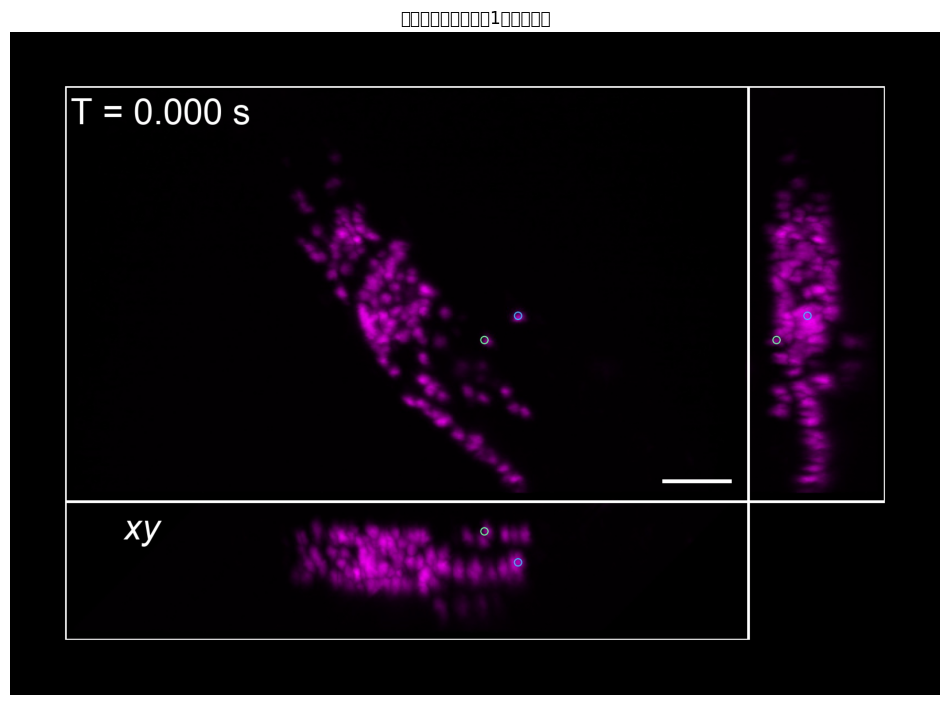

In [15]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

# === 入力設定 ===
input_path = "/Users/yuusuke/Downloads/Videos/True_Video9/plot_video_ch1_corrected_coords.avi"
timestamp_csv_path = "Worm2_Timestamps.csv"
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font_path_I = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"

# === タイムスタンプ読み込み ===
df = pd.read_csv(timestamp_csv_path)
timestamps = df["Delta"].values
print("✔ timestamps:", timestamps[:5])

# === フォント設定 ===
font_size = 65
font = ImageFont.truetype(font_path, font_size)
font_I = ImageFont.truetype(font_path_I, font_size)

def put_text_arial(img, text, position, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def put_text_arial_italic(img, text, position, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_I, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# === フレーム読み込み ===
cap = cv2.VideoCapture(input_path)
ret, frame = cap.read()
cap.release()
print("✔ ret:", ret)
if not ret:
    raise RuntimeError("❌ 最初のフレームが読み込めません")
height, width = frame.shape[:2]

# === 描画パラメータ（変更可）===
pad = 100
v_shift = 90
h_shift = 6
vertical_ratio = 0.75
horizontal_ratio = 5 / 6
scale_bar_length = 125
scale_bar_thickness = 6
scale_bar_margin_bottom = 50
scale_bar_margin_right = 150
white = (255, 255, 255)

# === ラベル位置・枠線 ===
xy_width = int(width * horizontal_ratio)
xy_height = int(height * vertical_ratio)

label_positions = {
    "xy": (h_shift + pad, xy_height - v_shift + pad),
    "xz": (h_shift + pad, height - v_shift + pad),
    "zy": (width - h_shift - 80 + pad, xy_height - v_shift + pad),
}
scale_bar_start = (
    xy_width - h_shift - scale_bar_margin_right + pad,
    xy_height - v_shift + scale_bar_margin_bottom + pad
)

# === 描画処理（1フレーム） ===
timestamp = timestamps[0]
frame = put_text_arial(frame, f"T = {timestamp:.3f} s", (10, 10), white)
for text, pos in label_positions.items():
    frame = put_text_arial_italic(frame, text, pos, white)

# スケールバーと枠線
x0, y0 = scale_bar_start
x1 = x0 + scale_bar_length
cv2.rectangle(frame, (x0 - pad, y0 - pad), (x1 - pad, y0 - pad + scale_bar_thickness), white, thickness=-1)
cv2.rectangle(frame, (0, 0), (xy_width, height), white, thickness=4)
cv2.rectangle(frame, (0, 0), (width, xy_height), white, thickness=4)

frame_padded = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

# === 表示 ===
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(frame_padded, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("レイアウト確認用：1フレーム目")
plt.show()


In [24]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

# === 入力設定 ===
input_path = "/Users/yuusuke/Downloads/Videos/True_Video9/plot_video_ch1_corrected_coords.avi"
timestamp_csv_path = "Worm2_Timestamps.csv"
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font_path_I = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"

# === タイムスタンプ読み込み ===
df = pd.read_csv(timestamp_csv_path)
timestamps = df["Delta"].values
print("✔ timestamps:", timestamps[:5])

# === フォント設定 ===
font_size = 65
font = ImageFont.truetype(font_path, font_size)
font_I = ImageFont.truetype(font_path_I, font_size)

def put_text_arial(img, text, position, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def put_text_arial_italic(img, text, position, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font_I, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# === フレーム読み込み ===
cap = cv2.VideoCapture(input_path)
ret, frame = cap.read()
cap.release()
print("✔ ret:", ret)
if not ret:
    raise RuntimeError("❌ 最初のフレームが読み込めません")
height, width = frame.shape[:2]

# === 描画パラメータ（変更可）===
pad = 10  # ← ここを自由に変更して確認可能
v_shift = 90
h_shift = 6
vertical_ratio = 0.75
horizontal_ratio = 5 / 6
scale_bar_length = 125
scale_bar_thickness = 6
scale_bar_margin_bottom = 50
scale_bar_margin_right = 150
white = (255, 255, 255)

# === ラベル・バー位置の基準座標（padなしのキャンバス上）===
xy_width = int(width * horizontal_ratio)
xy_height = int(height * vertical_ratio)

# pad=0の基準で定義（後でpadを加算）
label_positions_base = {
    "xy": (h_shift, xy_height - v_shift),
    "xz": (h_shift, height - v_shift),
    "zy": (width - h_shift - 80, xy_height - v_shift),
}
scale_bar_base = (
    xy_width - h_shift - scale_bar_margin_right,
    xy_height - v_shift ー scale_bar_margin_bottom
)


# pad分加算してラベル描画
label_positions = {
    key: (x + pad, y + pad)
    for key, (x, y) in label_positions_base.items()
}
scale_bar_start = tuple(np.array(scale_bar_base) + pad)

# === 描画処理（1フレーム） ===
timestamp = timestamps[0]
frame = put_text_arial(frame, f"T = {timestamp:.3f} s", (10, 10), white)

for text, pos in label_positions.items():
    frame = put_text_arial_italic(frame, text, pos, white)

# 枠線（pad=0 の位置で描画）
cv2.rectangle(frame, (0, 0), (xy_width, height), white, thickness=4)
cv2.rectangle(frame, (0, 0), (width, xy_height), white, thickness=4)

# パディング追加
frame_padded = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

# スケールバー（pad後のキャンバス上で描画）
x0, y0 = scale_bar_start
x1 = x0 + scale_bar_length
cv2.rectangle(frame_padded, (x0, y0), (x1, y0 + scale_bar_thickness), white, thickness=-1)

# === 表示 ===
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(frame_padded, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"pad={pad} のときの表示")
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2712918483.py, line 69)

/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENT

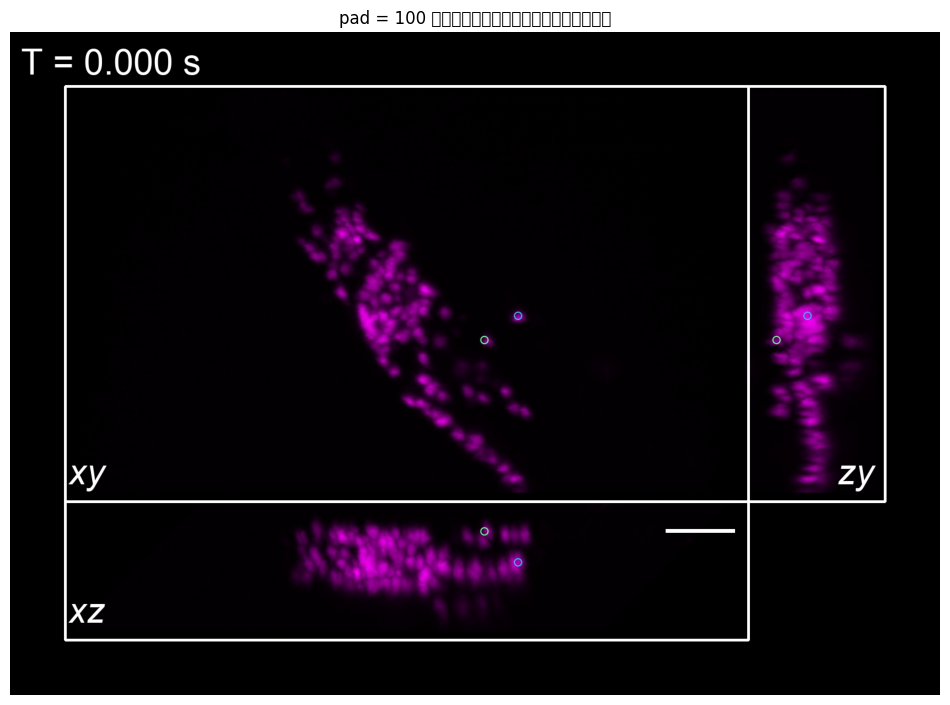

In [21]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

# === 入力設定 ===
input_path = "/Users/yuusuke/Downloads/Videos/True_Video9/plot_video_ch1_corrected_coords.avi"
timestamp_csv_path = "Worm2_Timestamps.csv"
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font_path_I = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"

# === タイムスタンプ読み込み ===
df = pd.read_csv(timestamp_csv_path)
timestamps = df["Delta"].values

# === フォント設定 ===
font_size = 65
font = ImageFont.truetype(font_path, font_size)
font_I = ImageFont.truetype(font_path_I, font_size)

def put_text_pil(img, text, position, font, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# === フレーム読み込み ===
cap = cv2.VideoCapture(input_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("❌ 最初のフレームが読み込めません")
height, width = frame.shape[:2]

# === パディングと表示調整 ===
pad = 0  # ← ここを変えて確認
white = (255, 255, 255)

# 画像の主要枠寸法
xy_height = int(height * 0.75)
xy_width = int(width * 5 / 6)

# === ラベル・スケールバー位置（padによらず固定） ===
v_shift = 90  # ラベル縦位置調整
h_shift = 6   # ラベル横位置調整
label_positions = {
    "xy": (pad + h_shift, pad + xy_height - v_shift),
    "xz": (pad + h_shift, pad + height - v_shift),
    "zy": (pad + width - h_shift - 80, pad + xy_height - v_shift),
}
scale_bar_length = 125
scale_bar_thickness = 6
scale_bar_margin_bottom = 50
scale_bar_margin_right = 150
scale_bar_start = (
    pad + xy_width - scale_bar_margin_right,
    pad + xy_height + scale_bar_margin_bottom
)

# === 描画処理 ===
frame_padded = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

# タイムスタンプ
timestamp = timestamps[0]
frame_padded = put_text_pil(frame_padded, f"T = {timestamp:.3f} s", (20, 20), font, white)

# ラベル描画
for key, pos in label_positions.items():
    frame_padded = put_text_pil(frame_padded, key, pos, font_I, white)

# スケールバー描画
x0, y0 = scale_bar_start
x1 = x0 + scale_bar_length
cv2.rectangle(frame_padded, (x0, y0), (x1, y0 + scale_bar_thickness), white, thickness=-1)

# 白枠線描画（XY枠 & XZ枠）
cv2.rectangle(frame_padded, (pad, pad), (pad + xy_width, pad + height), white, thickness=4)
cv2.rectangle(frame_padded, (pad, pad), (pad + width, pad + xy_height), white, thickness=4)

# === 表示 ===
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(frame_padded, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"pad = {pad} での表示（ラベル・スケールバー固定）")
plt.show()


/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuusuke/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETT

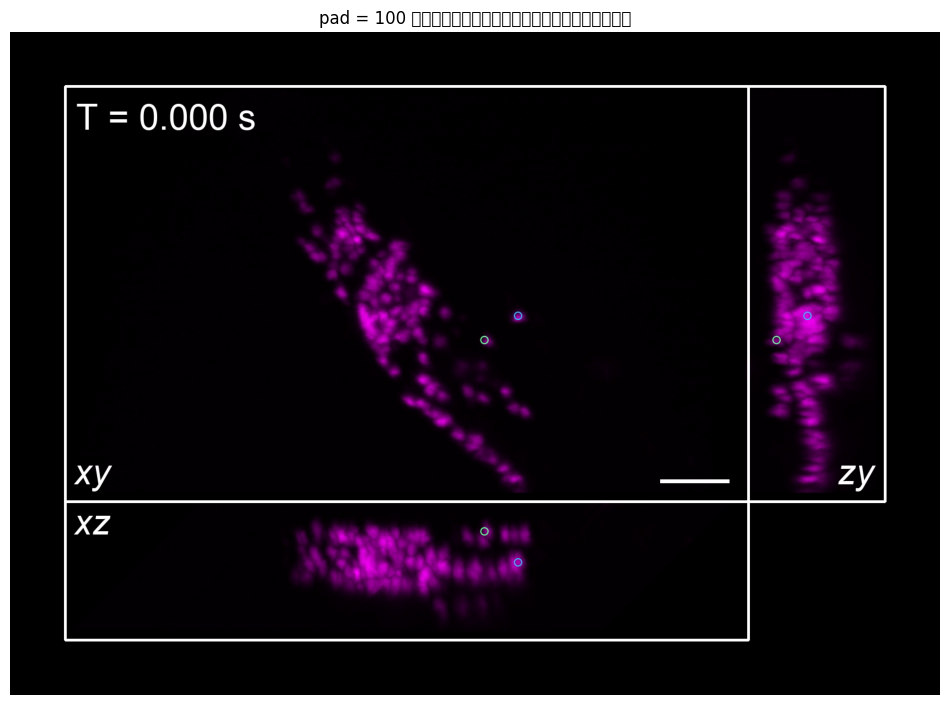

In [44]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

# === 入力設定 ===
input_path = "/Users/yuusuke/Downloads/Videos/True_Video9/plot_video_ch1_corrected_coords.avi"
timestamp_csv_path = "Worm2_Timestamps.csv"
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font_path_I = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"

# === タイムスタンプ読み込み ===
df = pd.read_csv(timestamp_csv_path)
timestamps = df["Delta"].values

# === フォント設定 ===
font_size = 65
font = ImageFont.truetype(font_path, font_size)
font_I = ImageFont.truetype(font_path_I, font_size)

def put_text_pil(img, text, position, font, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# === フレーム読み込み ===
cap = cv2.VideoCapture(input_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("❌ 最初のフレームが読み込めません")
height, width = frame.shape[:2]

# === パディングと表示調整 ===
pad = 100  # ← 任意に調整
white = (255, 255, 255)

# 白枠のXY/XZビューサイズ
xy_height = int(height * 0.75)
xy_width = int(width * 5 / 6)

# === ラベル位置（padに依存せず枠基準）===
v_shift = 90
h_shift = 6
label_positions = {
    "xy": (pad + h_shift+10, pad + xy_height - v_shift),
    "xz": (pad + h_shift+10, pad + height - v_shift-160),
    "zy": (pad + width - h_shift - 80, pad + xy_height - v_shift),
}

# === タイマー位置（画像左上からの相対位置） ===
timestamp_pos = (pad + 20, pad + 20)  # 枠の左上から20,20離れた場所に固定

# === スケールバー位置（枠の右下に相対固定） ===
scale_bar_length = 125
scale_bar_thickness = 6
scale_bar_margin_bottom = 40
scale_bar_margin_right = 160
scale_bar_start = (
    pad + xy_width - scale_bar_margin_right,
    pad + xy_height - scale_bar_margin_bottom
)

# === 描画処理 ===
frame_padded = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

# タイムスタンプ（padに依らず白枠左上から）
timestamp = timestamps[0]
frame_padded = put_text_pil(frame_padded, f"T = {timestamp:.3f} s", timestamp_pos, font, white)

# ラベル描画
for key, pos in label_positions.items():
    frame_padded = put_text_pil(frame_padded, key, pos, font_I, white)

# スケールバー描画（枠右下相対）
x0, y0 = scale_bar_start
x1 = x0 + scale_bar_length
cv2.rectangle(frame_padded, (x0, y0), (x1, y0 + scale_bar_thickness), white, thickness=-1)

# 白枠描画（XY, XZビュー）
cv2.rectangle(frame_padded, (pad, pad), (pad + xy_width, pad + height), white, thickness=4)
cv2.rectangle(frame_padded, (pad, pad), (pad + width, pad + xy_height), white, thickness=4)

# === 表示 ===
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(frame_padded, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"pad = {pad} の表示（ラベル・タイマー・スケールバー固定）")
plt.show()


In [45]:
import cv2
import numpy as np
import pandas as pd
import os
from PIL import ImageFont, ImageDraw, Image

# === フォント設定（必要に応じてパス変更） ===
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font_path_I = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"
font_size = 65
font = ImageFont.truetype(font_path, font_size)
font_I = ImageFont.truetype(font_path_I, font_size)

def put_text_pil(img, text, position, font, color=(255, 255, 255)):
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=color)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# === パス設定 ===
base_path = "/Users/yuusuke/Downloads/Videos/True_Video9"
input_path = os.path.join(base_path, "plot_video_ch1_corrected_coords.avi")
output_path = os.path.join(base_path, "movie8_labeled_worm2.mp4")
timestamp_csv_path = "Worm2_Timestamps.csv"

# === 動画読み込み設定 ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

fps = 50.943
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# === パディングと白枠設定 ===
pad = 100
out_width = width + pad * 2
out_height = height + pad * 2
white = (255, 255, 255)

# === 枠比率設定 ===
vertical_ratio = 0.75
horizontal_ratio = 5 / 6
xy_height = int(height * vertical_ratio)
xy_width = int(width * horizontal_ratio)

# === 位置設定（すべてpadに依存しない相対位置） ===
v_shift = 90
h_shift = 6
label_positions = {
    "xy": (pad + h_shift + 10, pad + xy_height - v_shift),
    "xz": (pad + h_shift + 10, pad + height - v_shift - 160),
    "zy": (pad + width - h_shift - 80, pad + xy_height - v_shift),
}
timestamp_pos = (pad + 20, pad + 20)

scale_bar_length = 125
scale_bar_thickness = 6
scale_bar_margin_bottom = 40
scale_bar_margin_right = 160
scale_bar_start = (
    pad + xy_width - scale_bar_margin_right,
    pad + xy_height - scale_bar_margin_bottom
)

# === タイムスタンプ読み込み ===
df = pd.read_csv(timestamp_csv_path)
if "Delta" not in df.columns:
    raise ValueError("❌ CSVに 'Delta' 列が見つかりません")
timestamps = df["Delta"].values

# === 出力動画設定 ===
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (out_width, out_height))
if not out.isOpened():
    raise RuntimeError("❌ 出力動画が作成できません")

print(f"▶ 処理中: {frame_count} フレーム")

# === メインループ ===
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # === パディング追加 ===
    frame_padded = cv2.copyMakeBorder(frame, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # === タイムスタンプ描画 ===
    timestamp = timestamps[i]
    frame_padded = put_text_pil(frame_padded, f"T = {timestamp:.3f} s", timestamp_pos, font)

    # === ラベル描画 ===
    for key, pos in label_positions.items():
        frame_padded = put_text_pil(frame_padded, key, pos, font_I)

    # === スケールバー描画 ===
    x0, y0 = scale_bar_start
    x1 = x0 + scale_bar_length
    cv2.rectangle(frame_padded, (x0, y0), (x1, y0 + scale_bar_thickness), white, thickness=-1)

    # === 白枠描画（XY, XZビュー）===
    cv2.rectangle(frame_padded, (pad, pad), (pad + xy_width, pad + height), white, thickness=4)
    cv2.rectangle(frame_padded, (pad, pad), (pad + width, pad + xy_height), white, thickness=4)

    # === 出力 ===
    out.write(frame_padded)

# === 終了処理 ===
cap.release()
out.release()
print("✅ 完了:", output_path)


▶ 処理中: 1725 フレーム
✅ 完了: /Users/yuusuke/Downloads/Videos/True_Video9/movie8_labeled_worm2.mp4
